Script for plotting the output of the combined predictive coding network and head direction spiking neural network on the NRP. This work is documented in the living machines 2022 submission 'Integrating Spiking Neural Networks and Deep Learning Algorithms on the Neurorobotics Platform'.

Required files: <br />
head_angle.csv
    - dataframe containing Time and head angle sampled at 50Hz <br />
all_spikes.csv 
    - dataframe containing Time and ID which are the spike times and corresponding cell number

These files are genrated by transfer functions in the NRP

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
from collections import Counter
import os

N = 180 # number of cells in simulation

folder = 'data/no_dropout_non-negative'

In [51]:
# load ground truth head angle from file
head_angle = pandas.read_csv(f'{folder}/head_angle.csv')
time = np.array(head_angle['Time'])
ground_truth = np.array(head_angle['Theta'])
theta = (ground_truth+np.pi)%(2*np.pi)-np.pi #wrap between pi and -pi
head_angle

,Time,Theta,Simulation_reset
0,0.02,-0.000010,NaN
1,0.04,-0.000010,NaN
2,0.06,0.005311,NaN
3,0.08,0.009790,NaN
4,0.10,0.016524,NaN
...,...,...,...
12272,245.46,70.332851,NaN
12273,245.48,70.339089,NaN
12274,245.50,70.345028,NaN
12275,245.52,70.350669,NaN


In [52]:
# load spikes from file
spikes = pandas.read_csv(f'{folder}/all_spikes.csv')
t = np.array(spikes['Time'])/1000
sp = np.array(spikes['ID']).astype(int)

To look at the error we first need to find the SNNs estimate of head angle (most active cell in each time window)

In [53]:
dt = 20
T = time

#find the most active cell in each 40ms bin
modes = np.zeros(len(T))
modes[:] = np.nan
rates = np.zeros((N,len(time)))
for i in range(len(T)-1):
    idx = (t>T[i])*(t<T[i+1]) # find all spikes in the bin
    lst = sp[np.where(idx)] # get the senders of those spikes
    occurence_count = Counter(lst) 
    mode = occurence_count.most_common(1) # find most common sender
    if len(mode):
        modes[i] = mode[0][0]
        
step = (2*np.pi)/N
modes = (modes*step) - np.pi

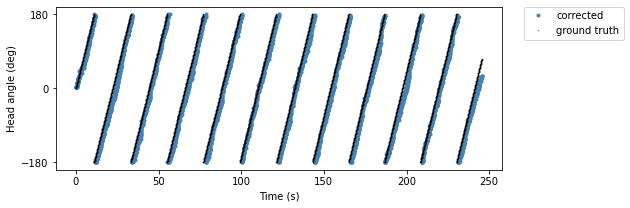

In [54]:
# fig, ax = plt.subplots(1, 1,figsize=(5, 2),facecolor='w')
fig, ax = plt.subplots(1, 1,figsize=(8, 3),facecolor='w')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Head angle (deg)')

ax.plot(T,modes*(180/np.pi),'.',label='corrected',color='steelblue')
ax.plot(np.array(time),(theta[:len(time)])*(180/np.pi),'.',markersize=.5,label='ground truth',color='black')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
plt.yticks([-180,0,180])
# plt.tight_layout()
plt.savefig(f'{folder}/drift.png')

To compare directly the ground truth and the estimated head angle we remove NaNs and interpolate the estimate to match the time series of the ground truth

In [55]:
nanidx = np.where(~np.isnan(modes[:-1]))
modes = modes[nanidx]
T=T[nanidx]

est = np.unwrap(modes)
groundTruth = np.unwrap(theta[:len(time)])
estimate = np.interp(time, T, est)

The difference between the estimated head angle and the ground truth is used to show how accumulation of drift over time, with total error measured as Root Mean Squared Error (RMSE).

21.522691635062237


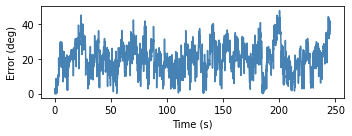

In [56]:
fig, ax = plt.subplots(1, 1,figsize=(5, 2),facecolor='w')

d = (groundTruth-estimate)
plt.plot(np.array(time),abs(d)*(180/np.pi),color='steelblue')
plt.xlabel('Time (s)')
plt.ylabel('Error (deg)')

RMSE = np.sqrt(np.sum(d**2)/len(d))
print(RMSE*(180/np.pi))

plt.tight_layout()
plt.savefig(f'{folder}/error.png')

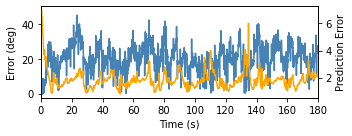

In [71]:
if os.path.exists(f'{folder}/predictions.csv'):
    predictions = pandas.read_csv(f'{folder}/predictions.csv')
    
    pred_time1 = np.array(predictions.Time)
    pred_error1 = np.array(predictions.Error)
    est1 = np.array(predictions['Bump Centre'])
    pred_time1 = pred_time1[pred_time1<=180]
    pred_error1 = pred_error1[:len(pred_time1)]
    
    fig, ax = plt.subplots(1, 1,figsize=(5, 2),facecolor='w')

    d = (groundTruth-estimate)
    plt.plot(np.array(time),abs(d)*(180/np.pi),color='steelblue')
    plt.xlabel('Time (s)')
    plt.ylabel('Error (deg)')

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.plot(pred_time1,pred_error1,label='prediction error',color='orange')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Prediction Error')

    plt.xlim([0,180])
    plt.tight_layout()
    plt.savefig(f'{folder}/pred_error.png')